In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pickle
import itertools
import random
import os
from src.encoders_decoders import *
from src.losses import *
from src.useful_functions import *
from torch.utils.data import DataLoader
from scipy.optimize import curve_fit
from lmfit import Model
from KDEpy import NaiveKDE
plt.rcParams['mathtext.fontset'] ='cm'
plt.rc('font',family= 'sans-serif', size=22)          # controls default text sizes
plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
# Example of notebook for analyses

In [3]:
#Set working directory
datadir = os.getcwd() + "/data/"
#datadir = os.getcwd() + "/data/Bernoulli"
plotsdir = os.getcwd()+"/Plots/Ising/Log_Normal_1_1"#"/Plots/Ising/Normal_0_5"# 
files = os.listdir(datadir)
if not os.path.isdir(plotsdir):
    os.makedirs(plotsdir)
files

['LN_prior_N=12_q=Ising_lrs=1_7_Ntrn=500.pt',
 'LN_prior_samples=500_N=12_q=Ising_lrs=15.pt',
 'LN_prior_N=12_q=Ising_example.zip',
 'subj_3',
 'LN_prior_samples=1000_N=12_q=Bernoulli_lrs=15.pt',
 'subj_2',
 'LN_prior_samples=100_N=12_q=Ising_lrs=1_7.pt',
 'LN_prior_LNdec_samples=2000_N=12_q=Ising_lrs=15.pt',
 'LN_prior_N=12_q=Ising_lrs=1_5_Ntrn=100.pt',
 'LN_prior_samples=500_N=12_q=Ising_lrs=1_7.pt',
 'subj_1',
 'LN_prior_samples=2000_N=12_q=Ising_lrs=15.pt',
 'LN_prior_samples=50_N=12_q=Ising_lrs=15.pt',
 'LN_prior_samples=500_N=12_q=Ising_lrs=05.pt',
 'LN_prior_samples=250_N=12_q=Ising_lrs=15.pt',
 'LN_prior_samples=100_N=12_q=Ising_lrs=15.pt',
 'speed_dist_enc=LN_N=12_q=Ising_lrs=1_5.pt',
 'LN_prior_samples=1000_N=12_q=Ising_lrs=15.pt']

In [4]:
#Set paramrs of the stimulus distribution, number of neurons
N = 12
data = torch.load(os.path.join(datadir,files[-2]))
p_x = torch.distributions.log_normal.LogNormal(1,1)
x_i =  p_x.sample((10000,))[:,None]
x_test_,_ = (p_x.sample((10000,))[:,None]).sort(dim=0)
x_min,x_max = x_test_[0,:].item(),x_test_[-1,:].item()
x_fine = torch.linspace(x_min,x_max,10000)[:,None]
H_p = p_x.entropy().item()

In [44]:
# Select a given simulation (one trial and one target rate)
#for n in range(16):
res = data[10] # One single trial
R_vec = list(res.keys())
i=5
print(R_vec[i])
data_R = res[R_vec[i]]
history_ = data_R['history']
#x_test_ = data_R['x_test']
enc_ = BernoulliEncoderLN(N,0,1,x_test_,w=2) 
dec_ = MLPDecoder(N,100)
q_ = rate_ising(N)
#q_ = rate_bernoulli(N)
q_.load_state_dict(data_R['q'])
enc_.load_state_dict(data_R['encode'])
dec_.load_state_dict(data_R['decoder'])
print(history_['distortion_test'][-1])

1.9857142857142858
1.0515460968017578


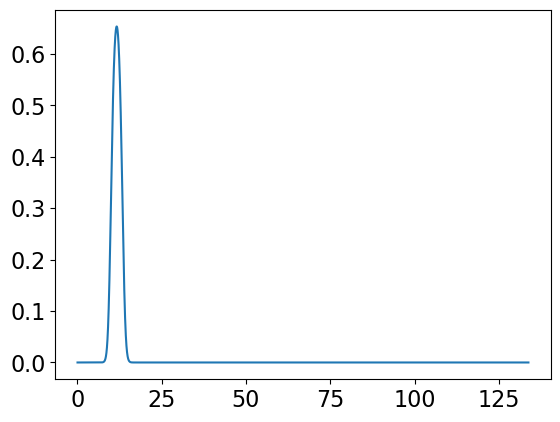

In [45]:
plt.plot(x_fine,torch.sigmoid(enc_(x_fine))[:,3].detach())

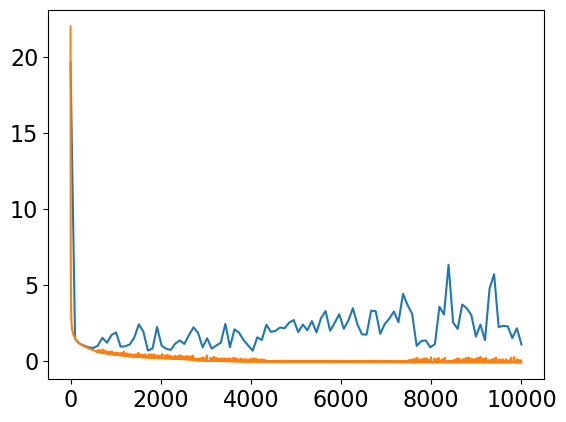

In [77]:
plt.plot(np.linspace(0,10000,100),history_['distortion_test'])
plt.plot(np.linspace(0,10000,10000),history_['distortion'])

In [78]:
history_['rate_test'] = [r.detach().item() for r in history_['rate_test']]

AttributeError: 'float' object has no attribute 'detach'

(0.0, 10.0)

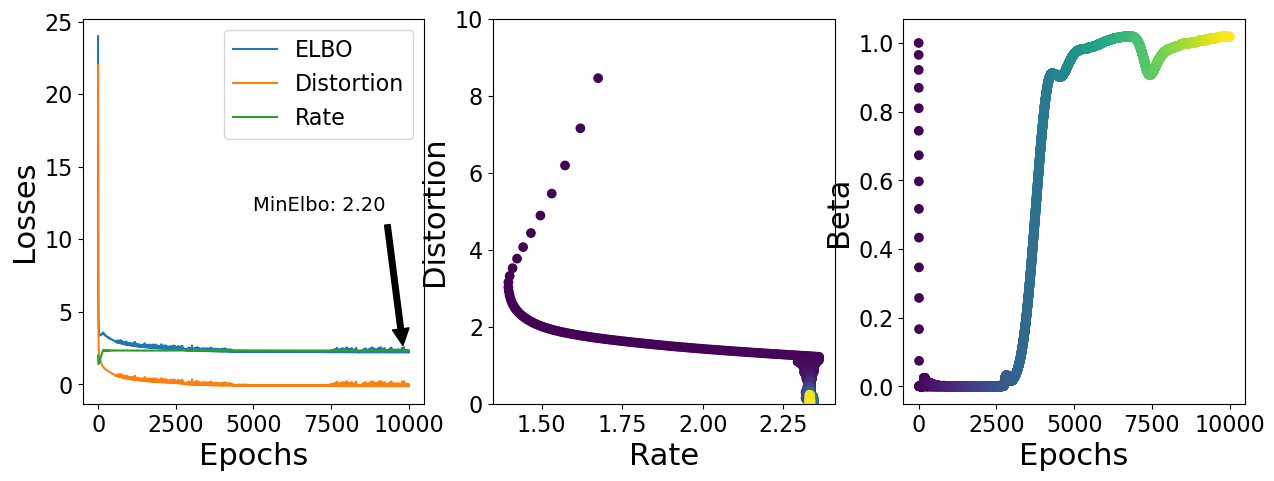

In [79]:
# Plot evolution  training dynamics
fig,ax = training_plots(history_["loss"],history_["distortion"],history_["rate"],history_["beta"])
#fig,ax = training_plots(history_["loss"],history_["distortion"],history_["rate"],history_["beta"])
ax[1].set_ylim(0,10)
#fig.savefig(plotsdir+f"/training_losses_#0_R{R_vec[i]}.pdf")

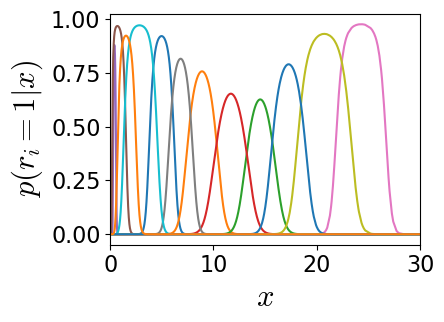

In [32]:
# Plot tuning curves
with torch.no_grad():
    #mu_dec,log_sigma_dec = decoder(r)
    fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(4,3))
    ax.plot(x_test_,torch.sigmoid(enc_(x_test_)))
    ax.set(xlabel=r"$x$",ylabel = r"$p(r_i=1|x)$",xscale="log",xlim=(0,130))#xticks =[0.1,1,10,100],yticks = [0,0.5,1])
#fig.savefig(plotsdir+f"/tuning_curves_R{R_vec[i]:.2f}.svg")

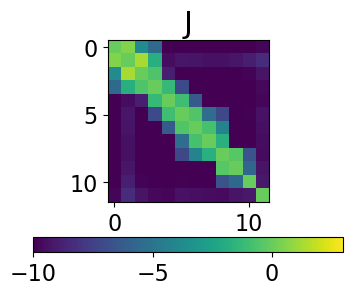

In [81]:
# Plot coupling matrix
with torch.no_grad():
    fig,axs = plt.subplots(figsize=(4,3))
    _,indices = enc_.cs.sort(dim=1)
    indices = torch.squeeze(indices)
    im= axs.imshow(q_.J[:,indices][indices,:],vmin=-10,vmax = 3)
    plt.colorbar(im,ax=axs,location= "bottom")
    axs.set_title('J')
#fig.savefig(plotsdir+f"/J_matrix_R{R_vec[i]:.2f}.svg")

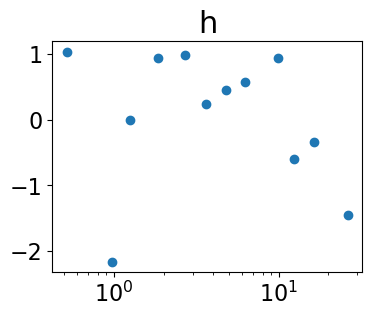

In [82]:
# Plot biases
with torch.no_grad():
    fig,axs = plt.subplots(figsize=(4,3))
    _,indices = enc_.cs.sort(dim=1)
    indices = torch.squeeze(indices)
    axs.scatter(enc_.cs[0,indices],q_.h[0,indices])
    axs.set(title='h',xscale="log")

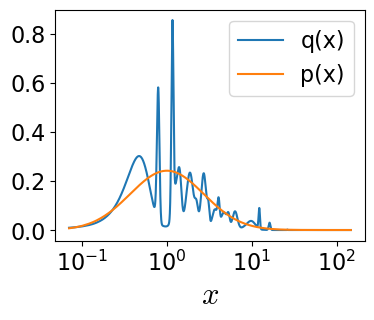

In [83]:
# Plot stimulus vs generative distribution
with torch.no_grad():
    fig,axs = plt.subplots(figsize=(4,3))
    mu_dec_all,log_sigma_all = dec_(q_.r_all.transpose(0,1)[:,None,:])
    q_r = torch.softmax(q_.h@q_.r_all + (q_.r_all*(q_.J@q_.r_all)).sum(dim=0),1)
    #q_r = torch.softmax(q_.h@q_.r_all,1)
    wq = torch.distributions.Categorical(q_r)
    gsq = torch.distributions.normal.Normal(mu_dec_all,torch.exp(log_sigma_all))
    q_x = torch.distributions.mixture_same_family.MixtureSameFamily(wq,gsq)
    axs.plot(x_test_,torch.exp(q_x.log_prob(x_test_)),label= "q(x)")
    axs.plot(x_test_,torch.exp(p_x.log_prob(x_test_)),label= "p(x)")
    axs.legend()
    axs.set(xscale="log",xlabel=r"$x$",xticks =[0.1,1,10,100])
#fig.savefig(plotsdir+f"/generative_model_R{R_vec[i]:.2f}.svg")